### Import Libraries

In [1]:
# Standard imports
import torch
import torch.nn as nn
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt

# FrEIA imports
import FrEIA.framework as Ff
import FrEIA.modules as Fm

### Define Global Variables and Functions

In [2]:
BATCH_SIZE = 100                    # Batch size
N_DIM = 2                           # Number of dimensions
N_COUPLING_LAYERS = 8               # Number of coupling layers
N_SAMPLES = 200000                  # Number of samples
EPOCHS = 1000

# Define a subnet for use inside an affine coupling block
def subnet_fc(dims_in, dims_out):
    return nn.Sequential(nn.Linear(dims_in, 512),
                         nn.ReLU(),
                         nn.Linear(512, dims_out))

### Build INN Model

In [3]:
# A Simple chain of operations is collected by ReversibleSequential
inn = Ff.SequenceINN(N_DIM)
for k in range(N_COUPLING_LAYERS):
    inn.append(Fm.AllInOneBlock, subnet_constructor=subnet_fc, permute_soft=True)

# Initialize optimizers
optimizer = torch.optim.Adam(inn.parameters(), lr=0.001)

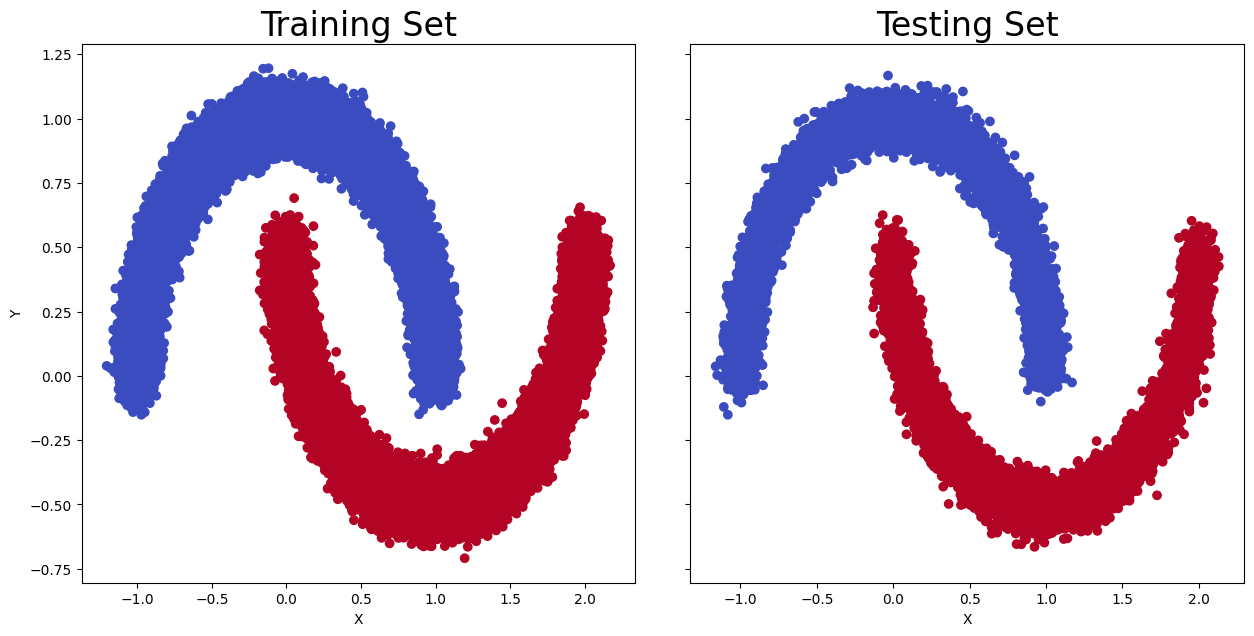

In [4]:
# Generate dataset
data, label = make_moons(n_samples=N_SAMPLES, noise=0.05, random_state=5323)

# Split into train, and test sets
X_train, X_test, y_train, y_test = train_test_split(data, label, test_size=0.1, random_state=5323)

y_train = y_train.reshape((y_train.shape[0], 1))
y_test = y_test.reshape((y_test.shape[0], 1))

# plot training/testing sets
f, ax = plt.subplots(1, 2, sharey=True, figsize=(15, 7))
ax[0].scatter(X_train[:,0], X_train[:,1], c=y_train, cmap='coolwarm')
ax[0].set_title('Training Set', fontsize=24)
ax[0].set_xlabel('X')
ax[0].set_ylabel('Y')
ax[1].scatter(X_test[:,0], X_test[:,1], c=y_test, cmap='coolwarm')
ax[1].set_title('Testing Set', fontsize=24)
ax[1].set_xlabel('X')
plt.subplots_adjust(wspace=0.1)
plt.show()

### Set the dataloader

In [5]:
# data loader
class LoadDataset(Dataset):
    def __init__(self, inputs_array, outputs_array):
        x_temp = inputs_array
        y_temp = outputs_array

        self.x_data = torch.tensor(x_temp, dtype=torch.float32) 
        self.y_data = torch.tensor(y_temp, dtype=torch.float32) 

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        current_input = self.x_data[idx, :]
        current_output = self.y_data[idx, :]
        
        sample = {'input': current_input,
                  'output': current_output}
        return sample
    

    def __len__(self):
        return len(self.x_data)

### Run Training

In [6]:
train_data = LoadDataset(X_train, y_train)
train_loader = DataLoader(dataset=train_data,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          drop_last=False)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"Training on: {torch.cuda.get_device_name(device)}")

# Run a very basic training loop
inn = inn.to(device)
N_DIM_t = torch.Tensor(N_DIM).to(device)
inn.train()
for i in range(EPOCHS):

    epoch_loss = 0
    #with tqdm(total=len(train_loader), desc='Epoch: {}/{}'.format(i, EPOCHS), disable=False) as t:
    for data in train_loader:

        # Zero out gradient from optimizer
        optimizer.zero_grad()

        # Sample data from the two-moons distributions
        #data, label = make_moons(n_samples=BATCH_SIZE, noise=0.05)
        #x = torch.Tensor(data)
        x,y = data['input'], data['output']
        x = x.to(device)
        y = y.to(device)

        # Pass to INN and get transformed variable z and log jacobian determinant
        z, log_jac_det = inn(x)

        # Calculate the negative log-likelihood of the model with a standard normal prior
        loss = 0.5*torch.sum(z**2, 1) - log_jac_det
        loss = loss.mean()
        epoch_loss += loss.item() 
        #loss = loss.mean()/N_DIM_t

        # Backpropagate and update the weights
        loss.backward()
        optimizer.step() 

        # Update tqdm
        #t.set_postfix_str('Train loss: {:.6f}'.format(epoch_loss/len(train_loader)))
        #t.update() 

    if i%100==0:
        print(f"Training iteration [{i}] - Train loss: {epoch_loss/len(train_loader)}")      

Training on: NVIDIA GeForce RTX 3090
Training iteration [0]


Epoch: 99/1000: 100%|██████████| 1800/1800 [00:09<00:00, 180.28it/s, Train loss: -1.517500]


Training iteration [100]


Epoch: 199/1000: 100%|██████████| 1800/1800 [00:09<00:00, 182.85it/s, Train loss: -1.524321]


Training iteration [200]


Epoch: 299/1000: 100%|██████████| 1800/1800 [00:10<00:00, 179.45it/s, Train loss: -1.526545]


Training iteration [300]


Epoch: 399/1000: 100%|██████████| 1800/1800 [00:09<00:00, 186.65it/s, Train loss: -1.529018]


Training iteration [400]


Epoch: 499/1000: 100%|██████████| 1800/1800 [00:10<00:00, 179.76it/s, Train loss: -1.530073]


Training iteration [500]


Epoch: 599/1000: 100%|██████████| 1800/1800 [00:10<00:00, 175.24it/s, Train loss: -1.531860]


Training iteration [600]


Epoch: 699/1000: 100%|██████████| 1800/1800 [00:09<00:00, 181.25it/s, Train loss: -1.532296]


Training iteration [700]


Epoch: 799/1000: 100%|██████████| 1800/1800 [00:10<00:00, 174.64it/s, Train loss: -1.532882]


Training iteration [800]


Epoch: 899/1000: 100%|██████████| 1800/1800 [00:09<00:00, 184.19it/s, Train loss: -1.533868]


Training iteration [900]


Epoch: 999/1000: 100%|██████████| 1800/1800 [00:10<00:00, 176.44it/s, Train loss: -1.534640]


### Evaluate INN Model

In [36]:
# Sample from the INN by sampling from a standard normal 
# and transforming it in the reverse direction
z = torch.randn(BATCH_SIZE*10, N_DIM).to(device)
inn.eval()
samples, _ = inn(z, rev=True)

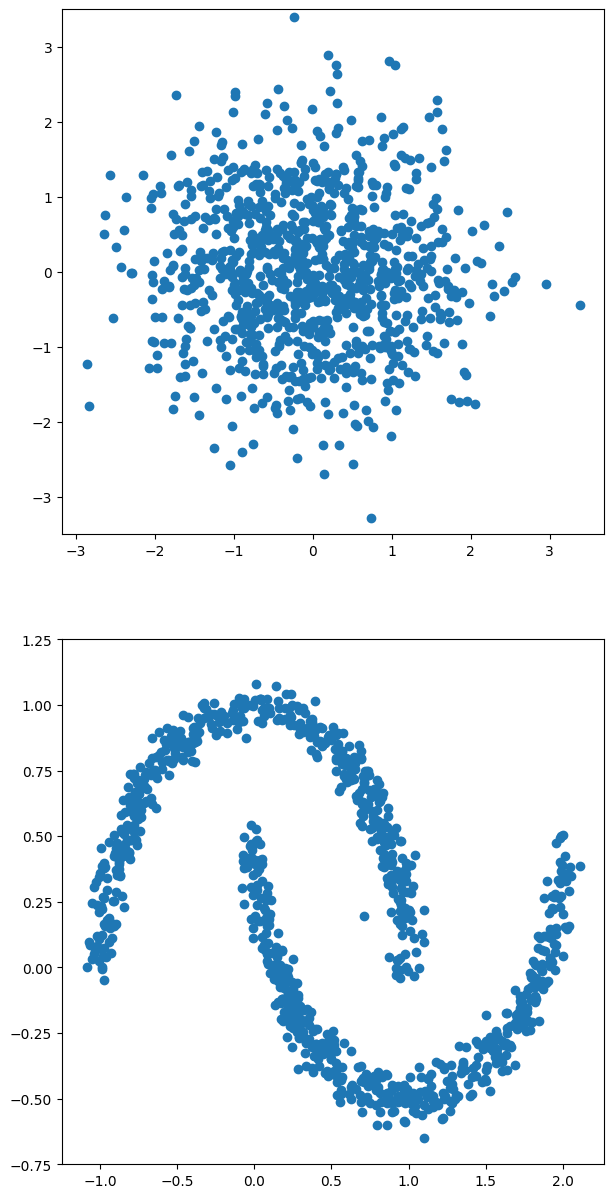

In [40]:
zp = samples.detach().cpu().numpy()
zd = z.detach().cpu().numpy()
f, ax = plt.subplots(2, 1, sharey=False, figsize=(7, 15))
ax[0].scatter(zd[:,0], zd[:,1]) #, cmap='coolwarm')
ax[0].set_ylim(-3.5,3.5)
ax[1].scatter(zp[:,0], zp[:,1]) #, cmap='coolwarm')
ax[1].set_ylim(-0.75,1.25)
plt.subplots_adjust(wspace=0.1)
plt.show()

### Forward Prediction

In [21]:
# Forward Prediction.
z = torch.from_numpy(X_test).type(torch.float32).to(device)
inn.eval()
samples, _ = inn(z, rev=False)

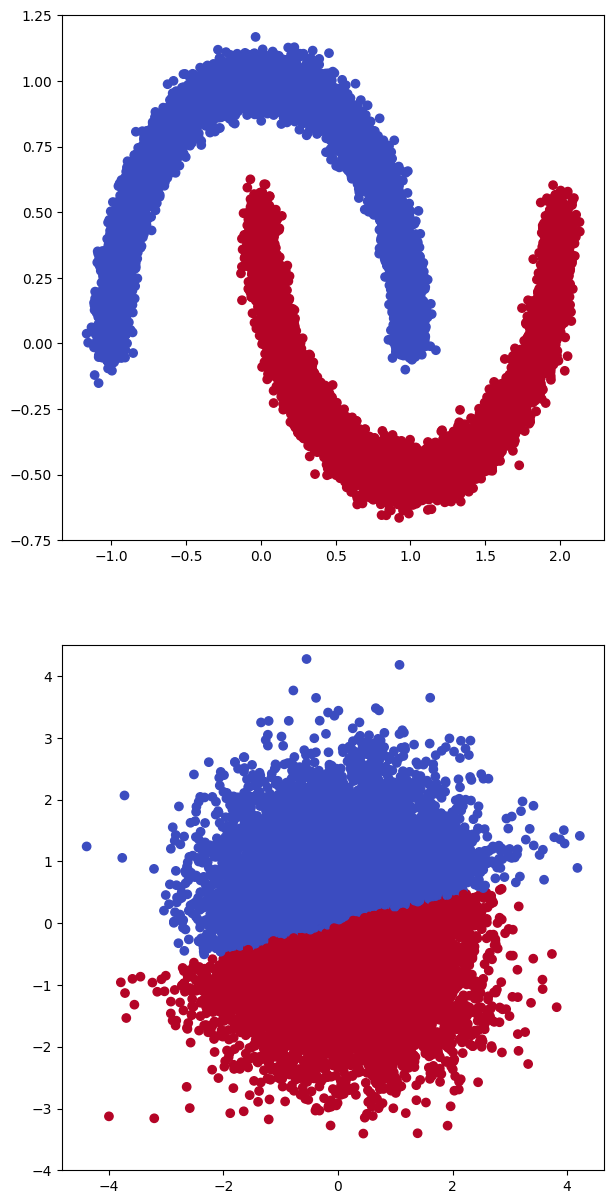

In [29]:
zp = samples.detach().cpu().numpy()
zd = z.detach().cpu().numpy()
f, ax = plt.subplots(2, 1, sharex=False, sharey=False, figsize=(7, 15))
ax[0].scatter(zd[:,0], zd[:,1], c=y_test, cmap='coolwarm')
ax[0].set_ylim(-0.75,1.25)
ax[1].scatter(zp[:,0], zp[:,1], c=y_test, cmap='coolwarm')
ax[1].set_ylim(-4,4.5)
#plt.subplots_adjust(wspace=0.1)
plt.show()

### Inverse Prediction

In [33]:
# Forward Prediction.
i_z = samples
inn.eval()
i_samples, _ = inn(i_z, rev=True)

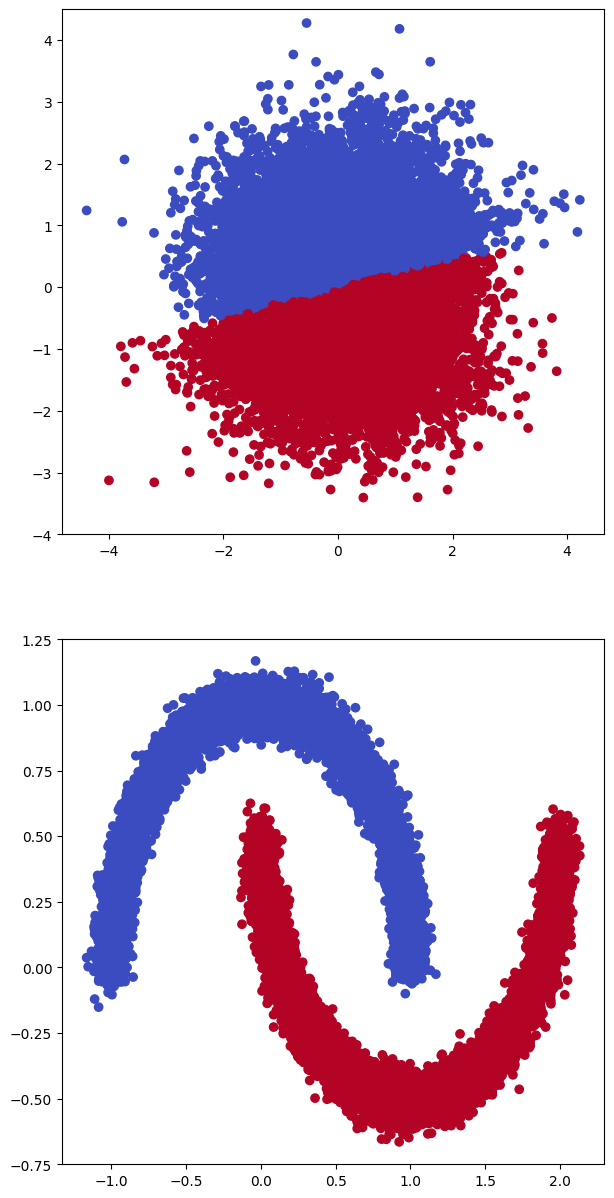

In [34]:
zp = i_samples.detach().cpu().numpy()
zd = i_z.detach().cpu().numpy()
f, ax = plt.subplots(2, 1, sharex=False, sharey=False, figsize=(7, 15))
ax[0].scatter(zd[:,0], zd[:,1], c=y_test, cmap='coolwarm')
ax[0].set_ylim(-4,4.5)
ax[1].scatter(zp[:,0], zp[:,1], c=y_test, cmap='coolwarm')
ax[1].set_ylim(-0.75,1.25)
#plt.subplots_adjust(wspace=0.1)
plt.show()